# Оконные функции

Научимся с помощью оконных функций получать значения соседних ячеек, не меняя при этом группировку строк. Изучим синтаксис оконных функций и попрактикуемся на различных примерах.

В ClickHouse нет оконных функций, поэтому подключаемся к Postgres

1) Посмотрим на продажи авокадо в двух городах (NewYork, LosAngeles) и узнаем, сколько авокадо типа organic было продано к концу каждой недели 
(накопительная сумма продаж), начиная с начала периода наблюдений (04/01/15). Значения внутри окна сортируйте по дате, а саму таблицу отсортируйте по убыванию региона (сначала NY, потом LA) и по возрастанию даты.

    SELECT 
        region,
        date,
        total_volume,
        sum(total_volume) OVER w AS volume
    FROM avocado
    WHERE 
        type = 'organic'
    AND region IN ('NewYork', 'LosAngeles')
    AND date >= '04/01/15'
    
    WINDOW w AS (
        PARTITION BY region
        ORDER BY date ASC 
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW 
        )
    ORDER BY 
        region DESC,
        date ASC 

2) Теперь добавьте разбивку по каждому году (year). Таким образом, в конце февраля 2016 года объем составят уже не продажи за 2015 и январь-февраль 2016, а только за январь-февраль 2016. Когда объемы продаж органических авокадо в Нью-Йорке превысили объемы продаж в Лос-Анджелесе?

Для решения задачи постройте график объема продаж в двух городах, где по оси X будет лежать дата. 

    SELECT 
        region,
        date,
        total_volume,
        sum(total_volume) OVER w AS volume
    FROM avocado
    WHERE 
        type = 'organic'
    AND region IN ('NewYork', 'LosAngeles')
    
    WINDOW w AS (
        PARTITION BY region, year
        ORDER BY date ASC 
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW 
        )
    ORDER BY 
        region DESC,
        date ASC
        
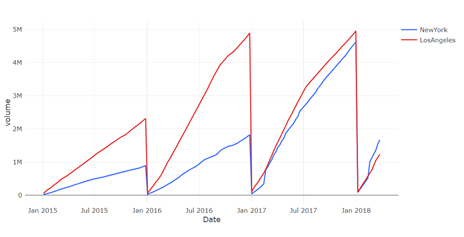

3) Посмотрим, когда объемы продаж обычных (conventional) авокадо резко падали по сравнению с предыдущей неделей. Возьмите данные по США в целом, посчитайте разницу между объемом продаж в неделю x (total_volume) и количеством проданных авокадо в течение предыдущей недели. Значения запишите в новый столбец week_diff.

    SELECT 
        date,
        total_volume,
        region,
        type,
        (total_volume – LAG(total_volume, 1)) OVER w AS week_diff
    FROM avocado
    WHERE 
        type = 'conventional'
    AND region IN ('TotalUS')
   
    WINDOW w AS ()
    ORDER BY 
        date ASC

4) Посмотрим более подробно на объемы продаж авокадо в Нью-Йорке (NewYork) в 2018 году. Создайте колонку с разницей объемов продаж за неделю и за неделю до этого для каждого типа авокадо. Найдите день, когда продажи авокадо типа organic увеличились по сравнению с предыдущей неделей, а conventional – наоборот упали. Если таких дней несколько, то укажите их через запятую с пробелом.
    
    SELECT 
        region,
        date,
        type,
        total_volume,
        (total_volume – LAG(total_volume, 1)) OVER w AS week_diff

    FROM avocado
    WHERE 
        region = 'NewYork'
        AND year = 2018  
   
    WINDOW w AS (
        PARTITION BY type 
        )
    ORDER BY 
        date ASC

5) Теперь посчитайте скользящее среднее цены авокадо (average_price) в Нью-Йорке с разбивкой по типу авокадо. В качестве окна используйте текущую неделю и предыдущие две (обратите внимание, что в данной таблице в строках содержатся данные за неделю, а не за один день). Например 04/01/15, 11/01/15 и 18/01/15 для подсчета значения для 18/01/15.

        SELECT 
            date,
            average_price,
            region,
            type,
          AVG(average_price) OVER w AS rolling_price
        FROM avocado
        WHERE 
            region = 'NewYork'
    WHERE 
        type = 'conventional'
        AND date = '2016-04-17'
    WINDOW w AS (
        PARTITION BY type
        ORDER BY date ASC 
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW 
        )
    ORDER BY 
        type,
        date 
